<a href="https://colab.research.google.com/github/shiva-tech-code/Defect-Detection-in-wall/blob/main/code3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python albumentations pandas matplotlib pillow

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from PIL import Image
import tensorflow as tf


# Mount Google Drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Mounted at /content/drive


In [ ]:
# Define paths and categories
DATA_DIR = '/content/drive/My Drive/dp/Wall_Defects_Dataset'
OUTPUT_DIR = '/content/drive/My Drive/Augmented_Dataset'
CATEGORIES = ['cracks', 'chipping', 'stains', 'paint_flaking', 'holes', 'no_defect']

In [ ]:


# Ensure output directory structure
os.makedirs(OUTPUT_DIR, exist_ok=True)
for category in CATEGORIES:
    os.makedirs(os.path.join(OUTPUT_DIR, category), exist_ok=True)

# Data Augmentation and Preprocessing Pipeline using Albumentations
augmentation_pipeline = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
])

In [ ]:

# Custom function to safely load and preprocess images
def safe_load_img(img_path, target_size=(224, 224)):
    try:
        img = load_img(img_path, target_size=target_size)
        return img_to_array(img) / 255.0  # Normalize image values
    except (IOError, ValueError) as e:
        print(f"Error loading image {img_path}: {e}")
        return None  # Return None if image cannot be loaded


In [ ]:
# Process each category folder and apply augmentation
for category in CATEGORIES:
    print(f"Processing {category} images...")
    img_dir = os.path.join(DATA_DIR, category)
    augmented_img_dir = os.path.join(OUTPUT_DIR, category)

    for img_name in tqdm(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, img_name)
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Failed to load {img_name}")
        except Exception as e:
            print(f"Skipping {img_name} due to error: {e}")
            continue  # Skip corrupted files or unsupported formats

        # Apply preprocessing (gray scale, CLAHE, resize)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_img = clahe.apply(gray)
        resized_img = cv2.resize(enhanced_img, (224, 224))

        # Save original processed image
        output_path = os.path.join(augmented_img_dir, f'proc_{img_name}')
        cv2.imwrite(output_path, resized_img)

        # Generate augmented images
        for i in range(3):  # Generate 3 augmented images per input
            augmented = augmentation_pipeline(image=image)['image']
            aug_img_path = os.path.join(augmented_img_dir, f'aug_{i}_{img_name}')
            cv2.imwrite(aug_img_path, augmented)



Processing cracks images...


100%|██████████| 45/45 [01:01<00:00,  1.37s/it]


Processing chipping images...


100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Processing stains images...


100%|██████████| 49/49 [01:01<00:00,  1.25s/it]


Processing paint_flaking images...


100%|██████████| 98/98 [02:07<00:00,  1.30s/it]


Processing holes images...


100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Processing no_defect images...


100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


In [ ]:
# Create CSV Manifest for Dataset
image_paths = []
labels = []

for category in CATEGORIES:
    category_dir = os.path.join(OUTPUT_DIR, category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        image_paths.append(img_path)
        labels.append(category)

In [ ]:
# Create DataFrame and save as CSV
import pandas as pd
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})
manifest_path = os.path.join('/content/drive/My Drive', 'dataset_manifest.csv')
df.to_csv(manifest_path, index=False)
print(f"Dataset manifest created as '{manifest_path}'.")

Dataset manifest created as '/content/drive/My Drive/dataset_manifest.csv'.


In [ ]:
# Load the augmented dataset from Google Drive
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Split data into 80% training and 20% validation
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)


In [ ]:
# Use the standard DirectoryIterator for training and validation
train_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # 80% of the data
)

validation_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # 20% of the data
)

Found 1003 images belonging to 6 classes.
Found 249 images belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


In [ ]:
# Build a CNN model with transfer learning from VGG16
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze VGG16 layers for feature extraction

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(CATEGORIES), activation='softmax')
    ])
    return model

In [ ]:
# Compile and train the model
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25
)

NameError: name 'build_model' is not defined

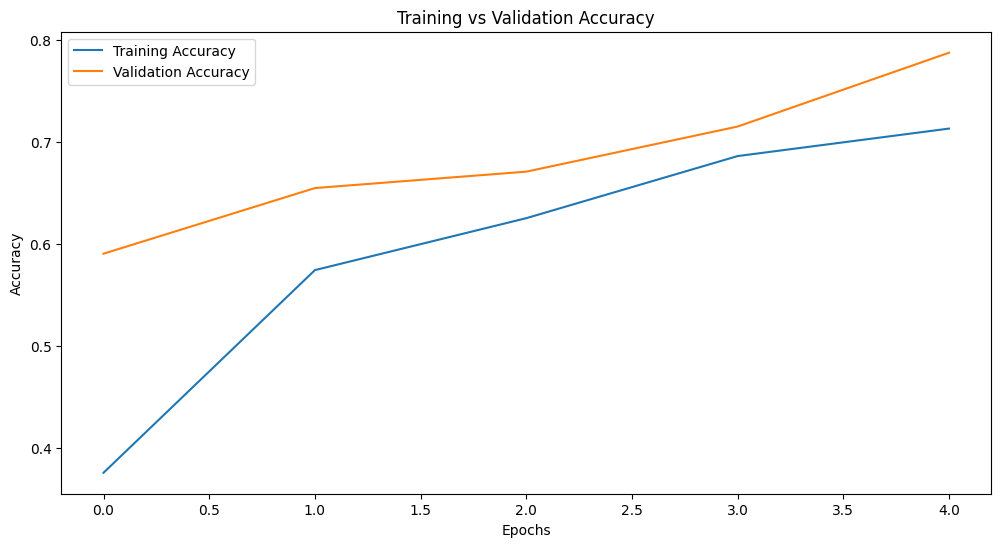

In [ ]:

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

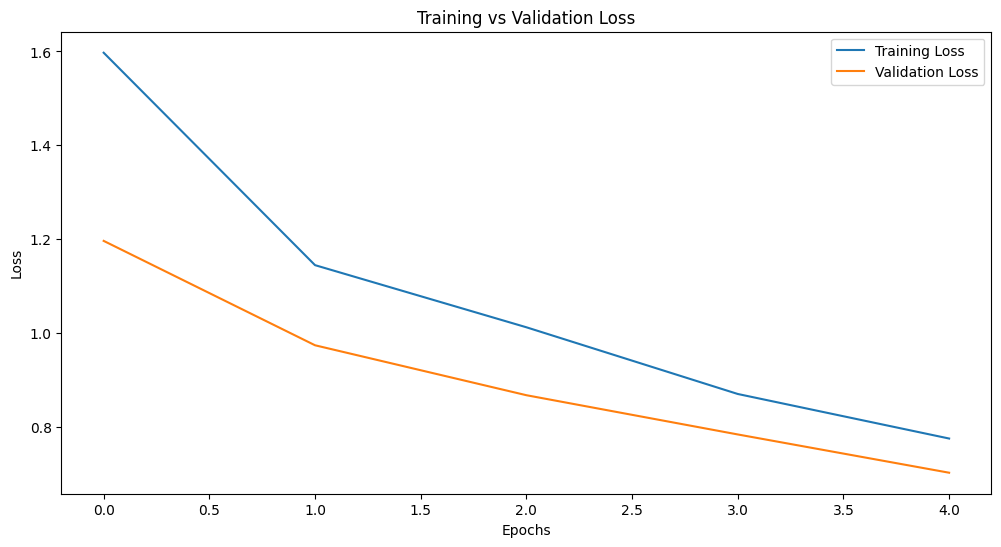

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Save the model
model_save_path = '/content/drive/My Drive/defect_detection_model.h5'
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 166s 20s/step - accuracy: 0.7537 - loss: 0.7135


Validation Loss: 0.7144721746444702
Validation Accuracy: 0.7469879388809204
Model saved at /content/drive/My Drive/defect_detection_model.h5


In [ ]:
# Function to detect defects in a new image
def detect_defect(img_path, model, categories=CATEGORIES):
    """
    Load a test image, preprocess it, and use the model to predict the defect type.
    Display the image with its predicted label in the terminal.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict defect type
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = categories[predicted_class[0]]pl

    # Display the image and prediction
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted Defect: {predicted_label}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Defect: {predicted_label}")
    return predicted_label
